# EDA - Data Transformation and Cleaning

In this notebook, I will be going through a process of analysing, visualizing a sample dataset, arriving at various decisions that improve our data's rigour. I will be using a mix of my own classes and methods, defined in `db_utils.py`, and various public libraries.

# Import local .csv

In [85]:
import pandas as pd

%reload_ext autoreload
%autoreload 2

df = pd.read_csv('cust_act1.csv') # Replace with relevant file here

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   administrative            11760 non-null  float64
 1   administrative_duration   11418 non-null  float64
 2   informational             12330 non-null  int64  
 3   informational_duration    11994 non-null  float64
 4   product_related           11751 non-null  float64
 5   product_related_duration  12129 non-null  float64
 6   bounce_rates              12330 non-null  float64
 7   exit_rates                12330 non-null  float64
 8   page_values               12330 non-null  float64
 9   month                     12330 non-null  object 
 10  operating_systems         12319 non-null  object 
 11  browser                   12330 non-null  object 
 12  region                    12330 non-null  object 
 13  traffic_type              12330 non-null  object 
 14  visito

# Perform column dtype transform

I perform these transformations in order to save on memory use throughout the project, 'category' being a more memory-efficient datatype than 'object'. We also cast a few float64 types to Int32 (nullable integers).

  Before the transformation, the DataFrame uses 1.4 MB of RAM, and only 857 KB afterwards, a reduction of nearly 40%. While not very significant for a db of this size, with larger datasets this would be a marked difference.

In [86]:
from db_utils import DataTransform
from db_utils import DataFrameInfo as dfinfo

dtype_change = {
    "visitor_type": "category",
    "traffic_type": "category",
    "region": "category",
    "browser": "category",
    "operating_systems": "category",
    # "months": "category" -- Special case
    "administrative": "Int32",
    "informational": "Int32",
    "product_related": "Int32"
}

""" dfinfo(df, 'operating_systems').unique()
print("\n", df['operating_systems'].value_counts())
print(df['operating_systems'].isna().sum()) """

# Perform special transform case for months to be an ordered category
months_ordered = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['month'] = pd.Categorical(df['month'], categories=months_ordered, ordered=True)
# Perform the transform from dict
df = DataTransform(df).changetype(dtype_change)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   administrative            11760 non-null  Int32   
 1   administrative_duration   11418 non-null  float64 
 2   informational             12330 non-null  Int32   
 3   informational_duration    11994 non-null  float64 
 4   product_related           11751 non-null  Int32   
 5   product_related_duration  12129 non-null  float64 
 6   bounce_rates              12330 non-null  float64 
 7   exit_rates                12330 non-null  float64 
 8   page_values               12330 non-null  float64 
 9   month                     12330 non-null  category
 10  operating_systems         12319 non-null  category
 11  browser                   12330 non-null  category
 12  region                    12330 non-null  category
 13  traffic_type              12330 non-null  cate

# Display No. and % of Null values

I first use my `dfinfo().null()` method to show a simple count of the missing values. We then use the `missingno` library to visualize the correlation between the presence or absence of variables. We also use Little's MCAR test, getting a p-value of ~0.95. This suggests the data is missing completely at random.

,ColumnName,CountNull,PercentageNull
0,administrative,570,4.62
1,administrative_duration,912,7.40
2,informational,0,0.00
3,informational_duration,336,2.73
4,product_related,579,4.70
5,product_related_duration,201,1.63
6,bounce_rates,0,0.00
7,exit_rates,0,0.00
8,page_values,0,0.00
9,month,0,0.00


0.9495907221356983


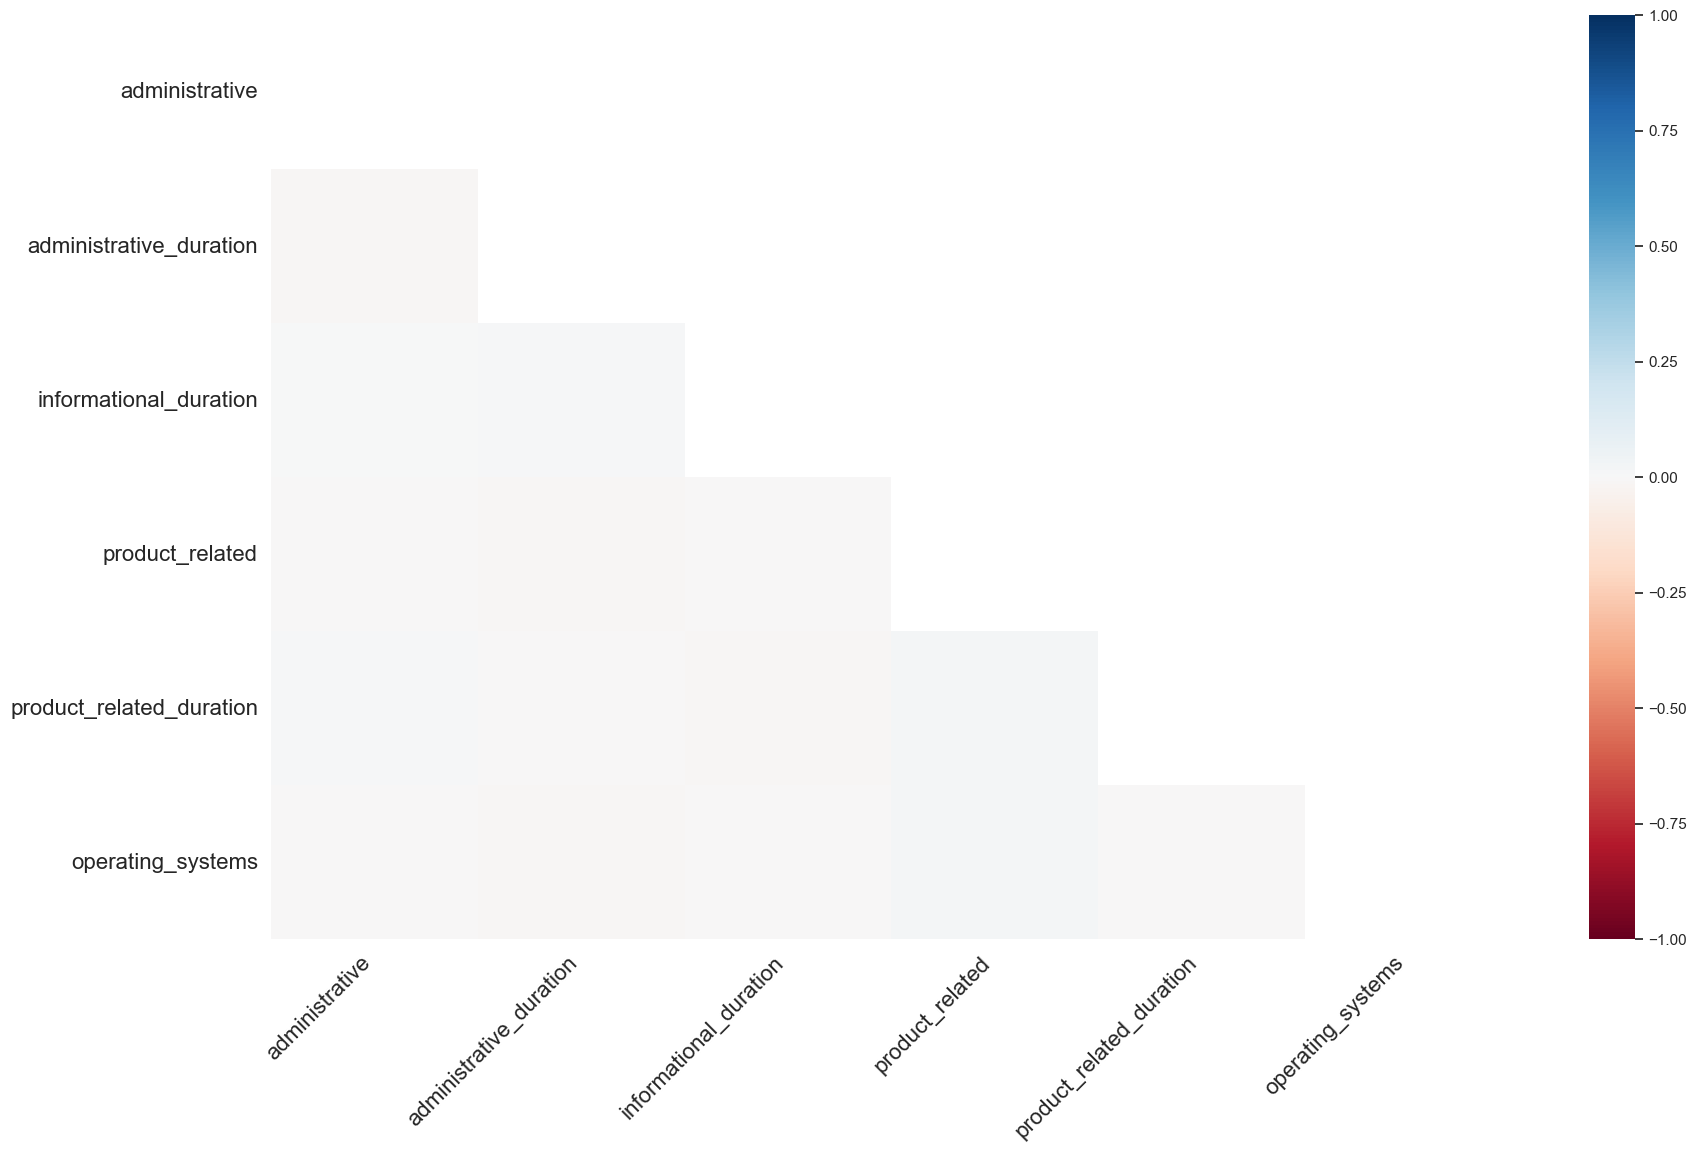

In [89]:
nulldf = dfinfo(df).null()
display(nulldf)

import missingno as msno
msno.heatmap(df)

from pyampute.exploration.mcar_statistical_tests import MCARTest
mt = MCARTest(method="little")
print(mt.little_mcar_test(df.select_dtypes(include=['int64', 'float64', 'Int32'])))

In [75]:
print("Missing 'product_related':\n")
missingprod = df.loc[df["product_related"].isna()]
display(missingprod[["product_related", "product_related_duration"]])
print("\nMissing 'administrative':\n")
missingadmin = df.loc[df["administrative"].isna()]
display(missingadmin[["administrative", "administrative_duration"]])

Missing 'product_related':



,product_related,product_related_duration
7,<NA>,1134.0
22,<NA>,1073.0
43,<NA>,946.0
51,<NA>,266.0
76,<NA>,1588.0
...,...,...
12233,<NA>,176.0
12264,<NA>,195.0
12290,<NA>,558.0
12321,<NA>,57.0



Missing 'administrative':



,administrative,administrative_duration
22,<NA>,85.966667
36,<NA>,0.000000
42,<NA>,0.000000
44,<NA>,0.000000
58,<NA>,0.000000
...,...,...
12190,<NA>,18.000000
12211,<NA>,198.000000
12292,<NA>,84.000000
12301,<NA>,36.600000


# Imputation Time
Here we deal with the null values.

I chose to impute the 3 'duration' columns with the median (the `dft.impute_missing()` method autoselects the mean or the median depending on Z-score derived skewness.), as it was a continuous value and the number of missing values was low enough to not be overly significant (1.5-7.5%).

I then dropped the OS column's null rows, as there were only 11 of them (less than 0.1%).

We then manually impute the 'administrative' and 'product_related' columns with the mode. As the values appear to be MCAR, we could spend more time on, perhaps, imputing 0s where the respective duration column is 0.00, however the missingness is low enough not to be worrisome.

In [76]:
from db_utils import DataFrameTransform as dft

%reload_ext autoreload
%autoreload 2

cols_to_impute_na = [
    "product_related_duration",
    "informational_duration",
    "administrative_duration"
]
cols_to_drop_na = [
    "operating_systems"
]
cols_to_mode_na = [
    "administrative",
    "product_related"
]

dft(df, cols_to_drop_na).drop_missing()
dft(df, cols_to_impute_na).impute_missing()
dft(df, cols_to_mode_na).impute_missing(strategy="mode")

dfinfo(df).null()

Dropped 11 rows with missing values in ['operating_systems'].
Imputed missing values in 'product_related_duration' with median (586.00, skew=3.64).
Imputed missing values in 'informational_duration' with median (0.00, skew=7.21).
Imputed missing values in 'administrative_duration' with median (6.00, skew=4.67).
Imputed missing values in 'administrative' with mode (0, skew=2.00).
Imputed missing values in 'product_related' with mode (1, skew=3.37).


,ColumnName,CountNull,PercentageNull
0,administrative,0,0.0
1,administrative_duration,0,0.0
2,informational,0,0.0
3,informational_duration,0,0.0
4,product_related,0,0.0
5,product_related_duration,0,0.0
6,bounce_rates,0,0.0
7,exit_rates,0,0.0
8,page_values,0,0.0
9,month,0,0.0


# Skewness Reduction Transformations

I experimented with log-transformation and the Yeo-Johnson power transformation to reduce skewness in the dataset. I found the Yeo-Johnson method to be more effective at producing a Gaussian distribution, however I did not make use of transformed data in this exercise as I did not need to apply any ML or linear regression.

Original DataFrame:


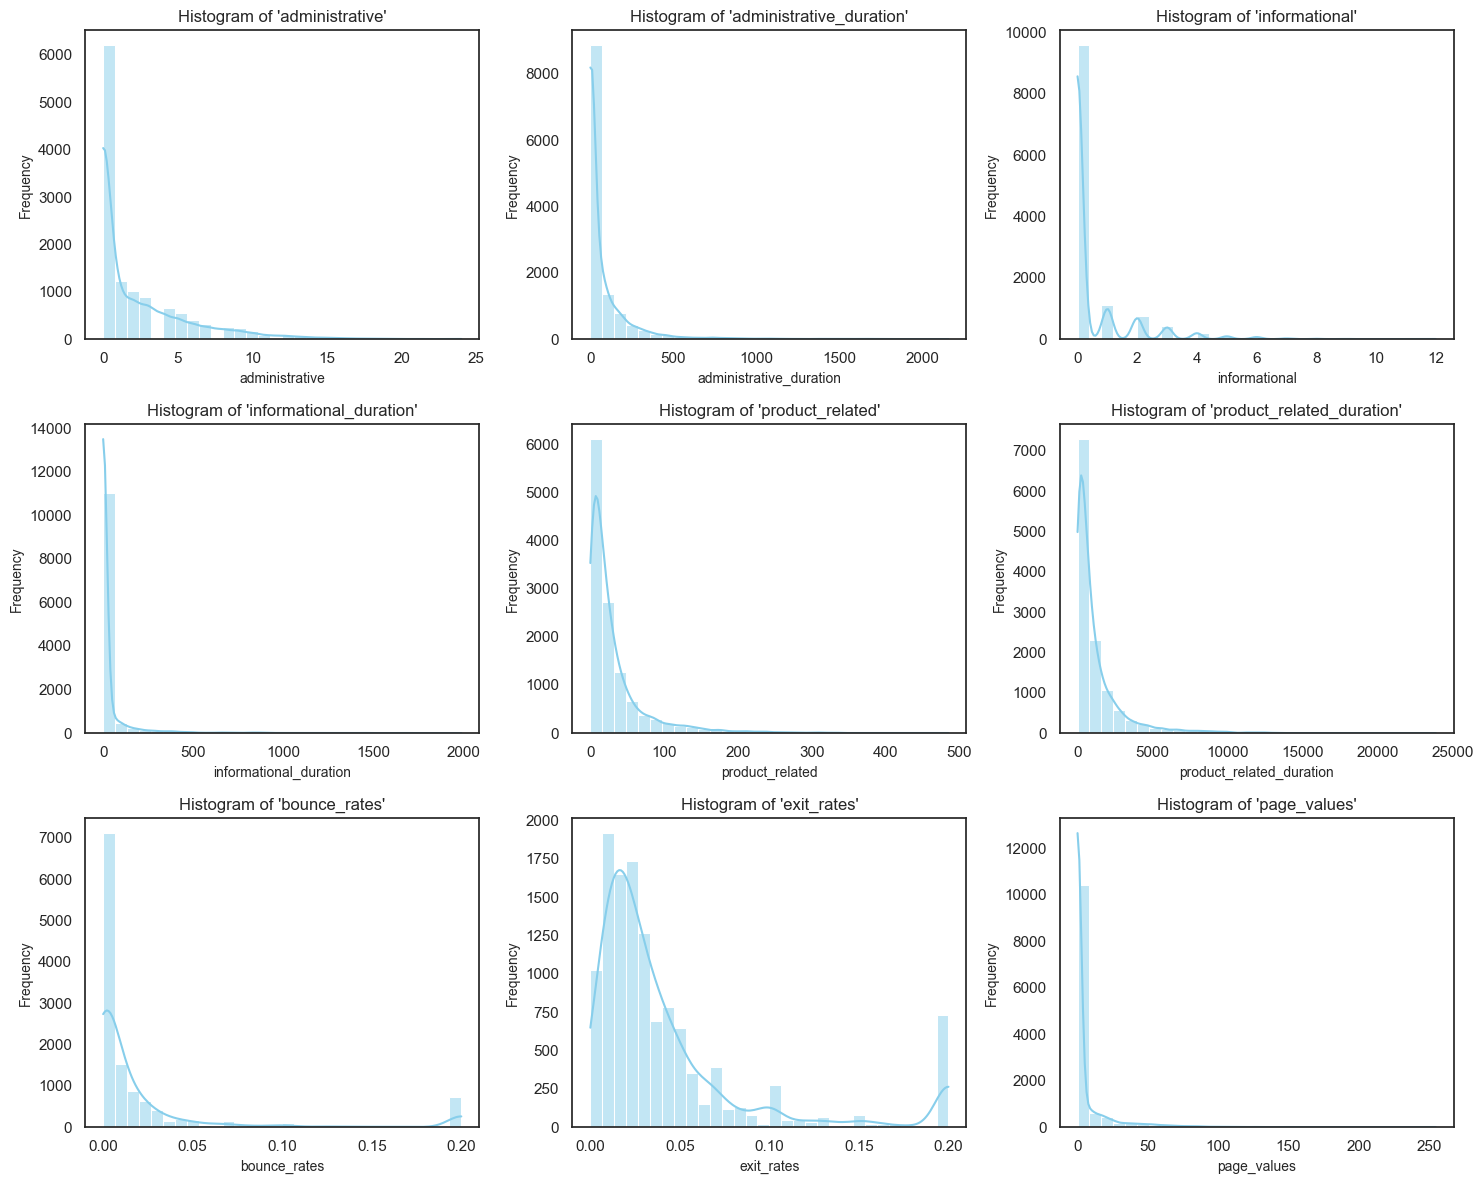


Log-Transformed DataFrame:


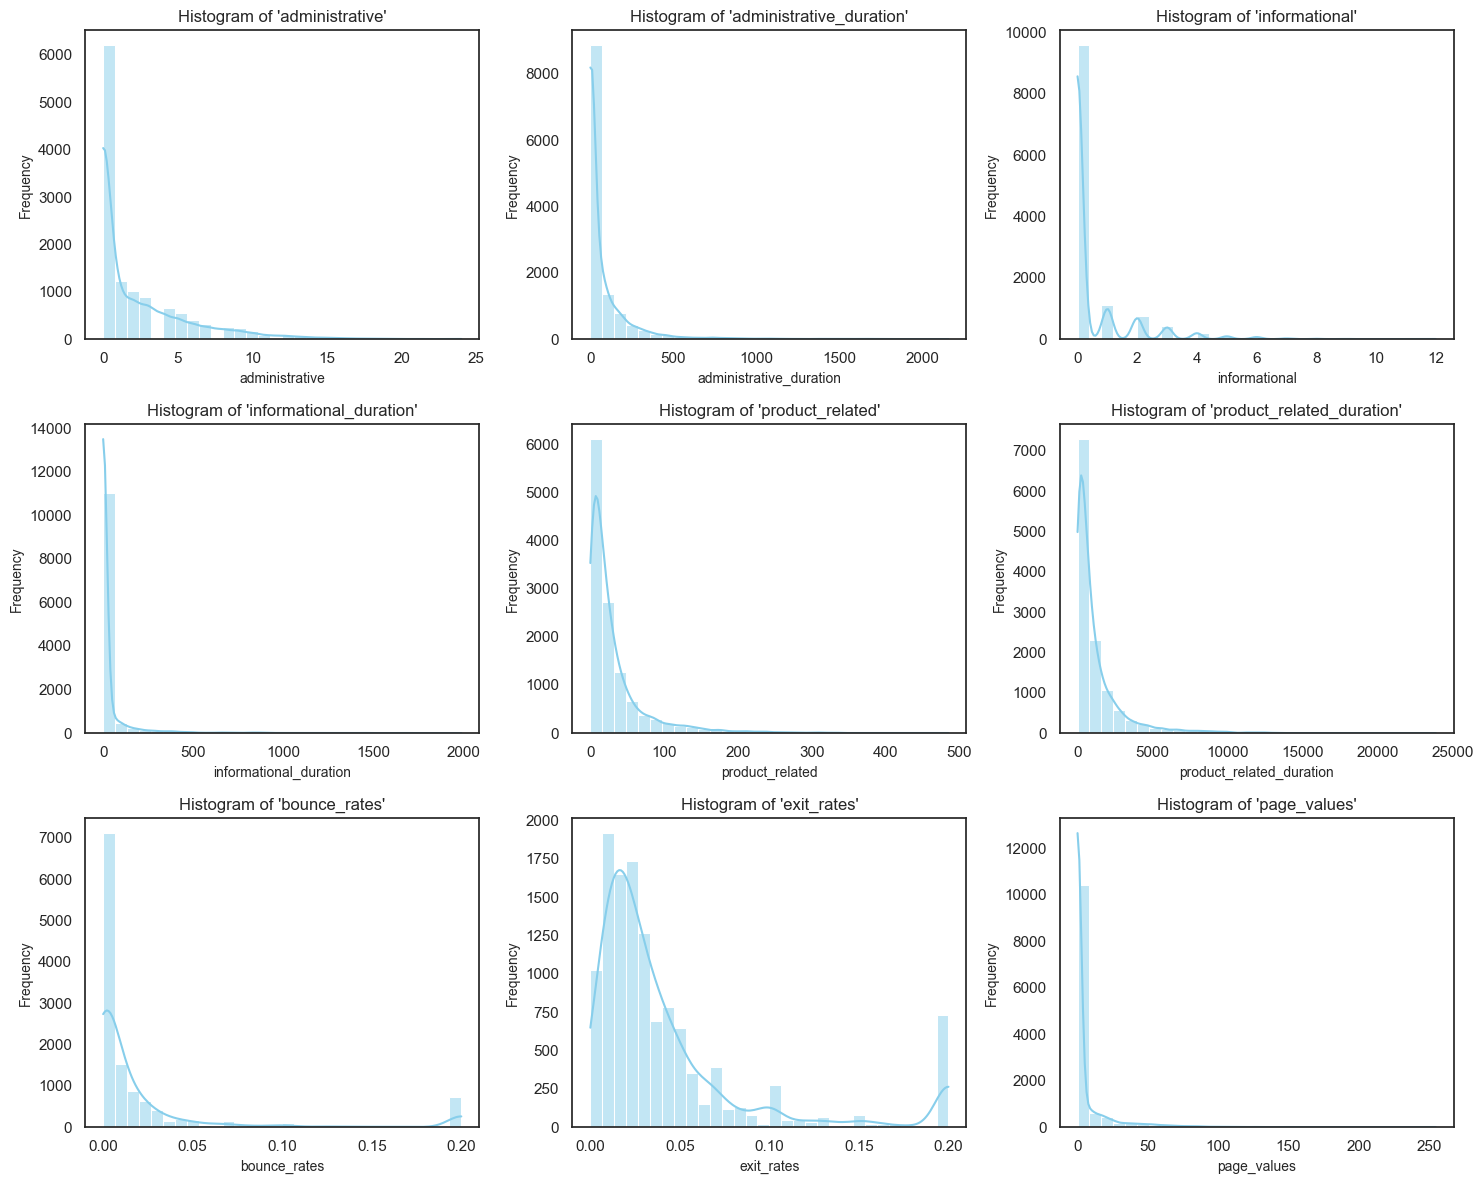


Power-Transformed DataFrame:


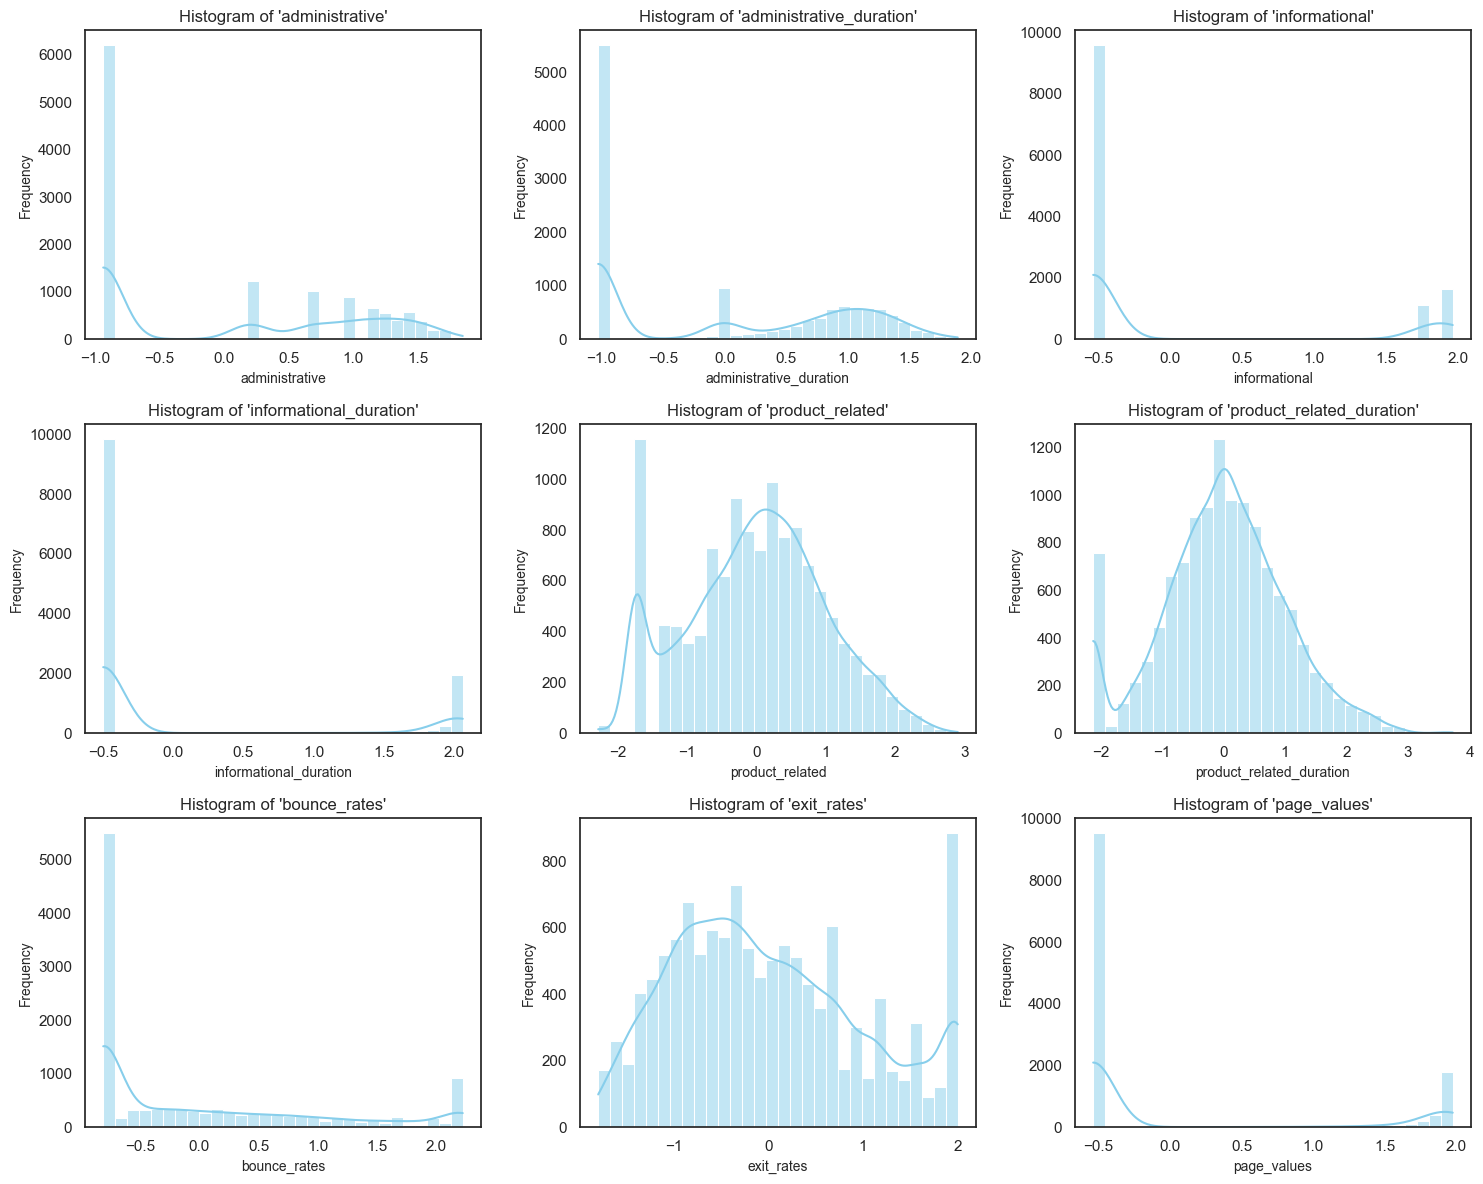

In [77]:
from db_utils import Plotter

df.skew(numeric_only=True)

print("Original DataFrame:")
Plotter(df).numeric_distributions()

# Apply log transformation
log_transformed_df = dft(df).reduce_skewness(method='log')
print("\nLog-Transformed DataFrame:")
Plotter(log_transformed_df).numeric_distributions()

# Apply PowerTransformer
power_transformed_df = dft(df).reduce_skewness(method='power')
print("\nPower-Transformed DataFrame:")
Plotter(power_transformed_df).numeric_distributions()



# Outlier Purge

### Before:

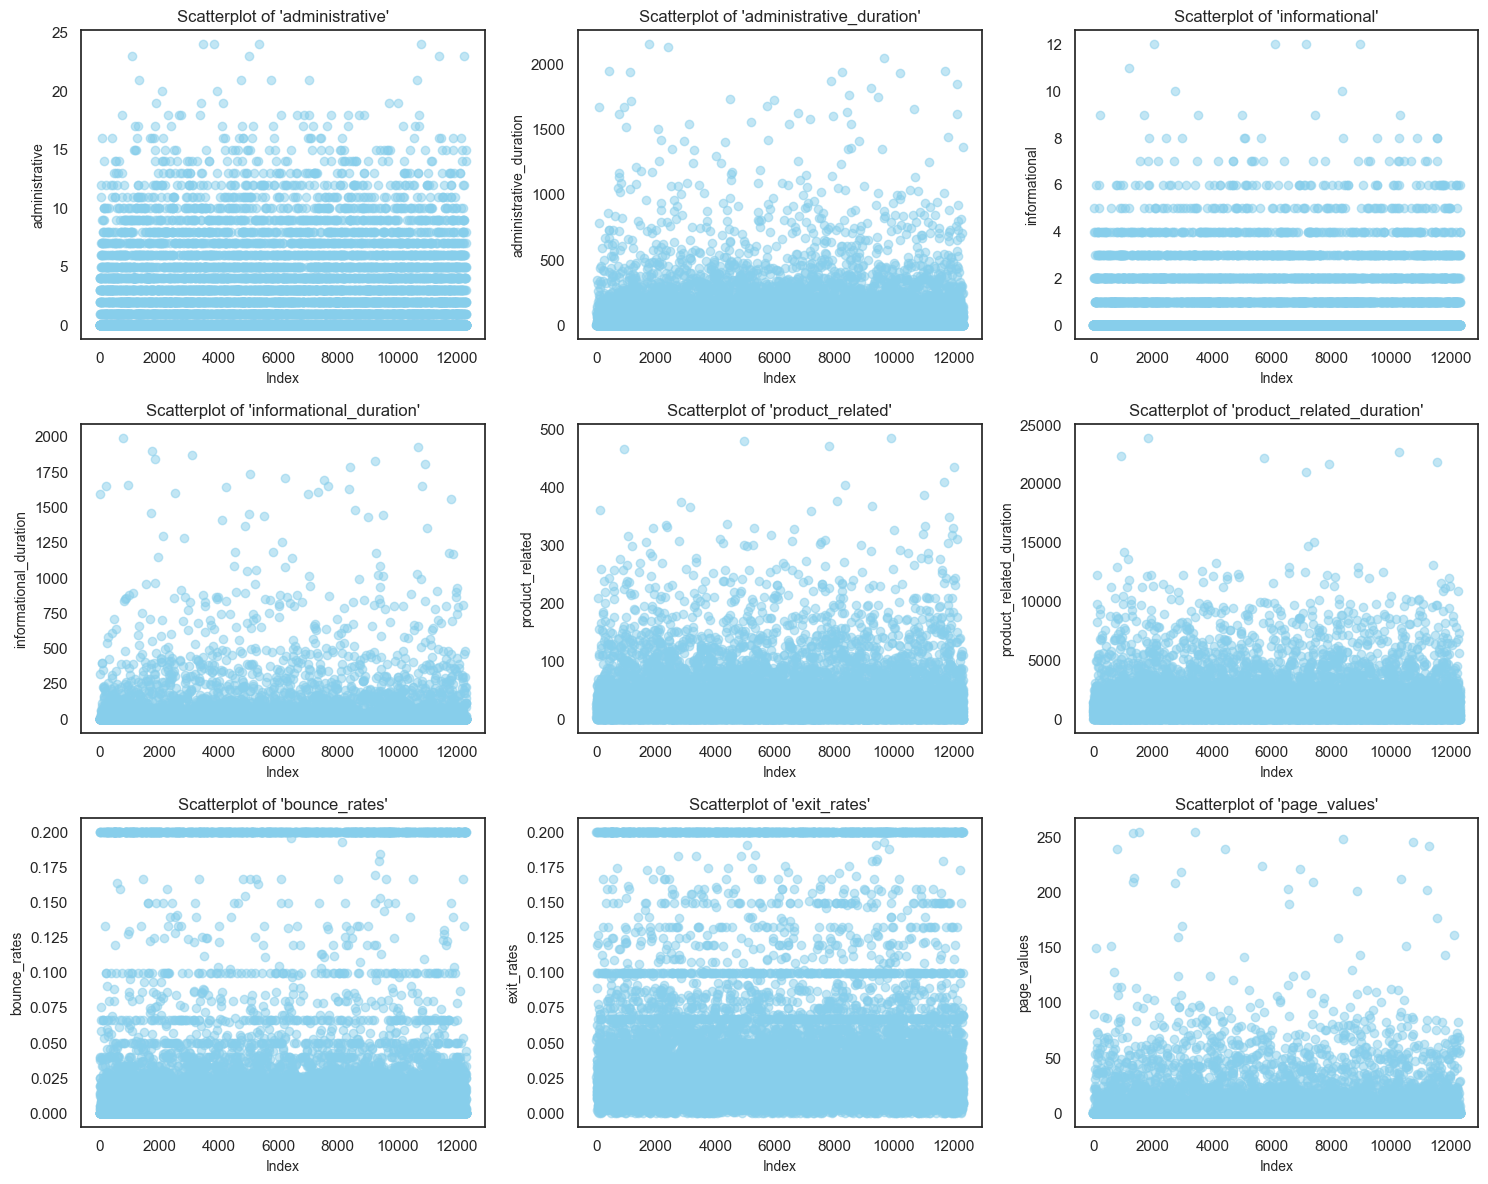

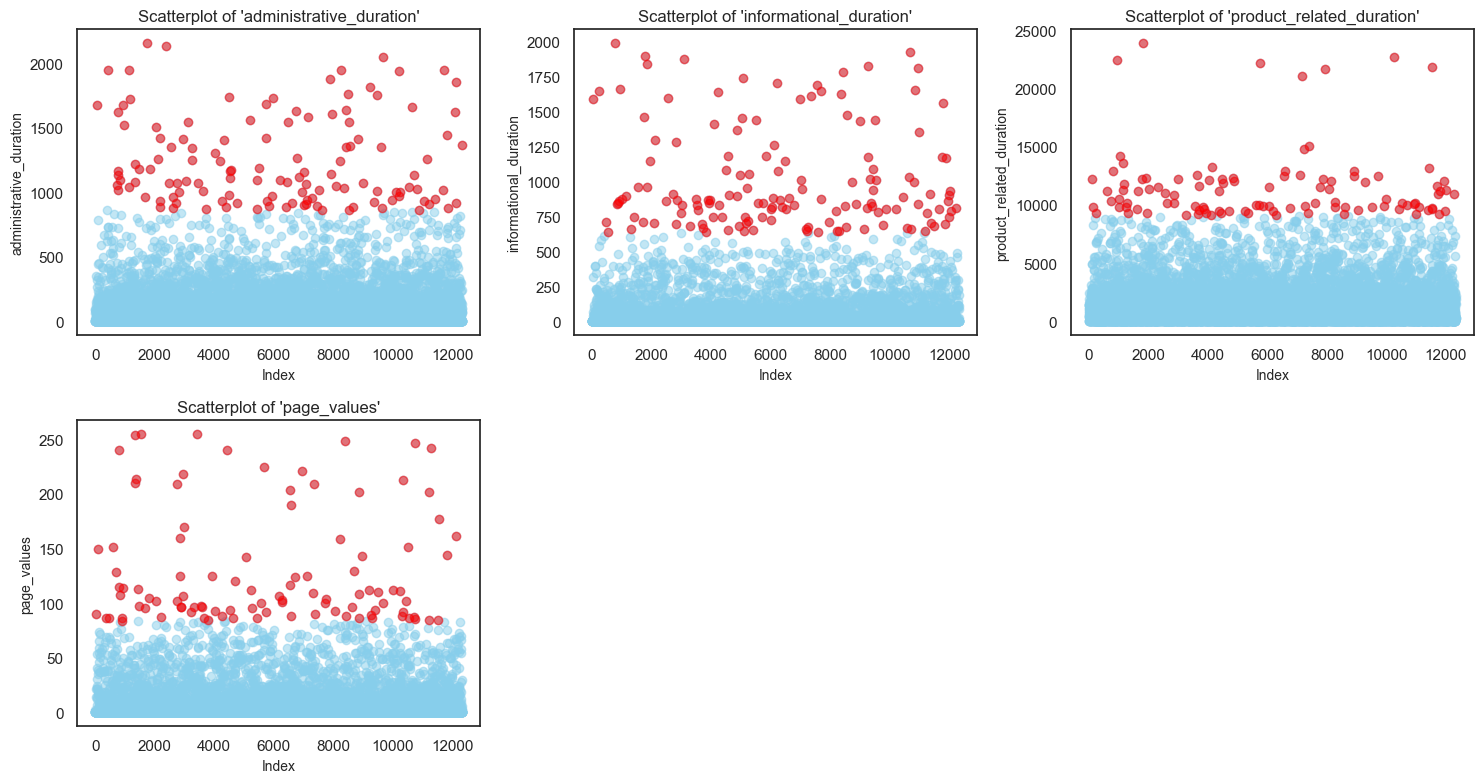

,Column,Z-Score Outliers,Z Percentage,IQR Outliers,IQR Percentage
0,administrative_duration,125,1.014693,1298,10.536570
1,informational_duration,145,1.177044,2471,20.058446
2,product_related_duration,107,0.868577,1054,8.555889
3,page_values,101,0.819872,2779,22.558649


In [78]:
Plotter(df).numeric_distributions(highlight_outliers=False, plot_type='scatter')

cols_with_outliers = [
    "administrative_duration",
    "informational_duration",
    "product_related_duration",
    "page_values"
]

Plotter(df).numeric_distributions(columns=cols_with_outliers, plot_type='scatter', z_threshold=4.5)

dfinfo(df, cols_with_outliers).count_outliers(z_treshold=4.5)

### Perform removal, assign to new dataframe

In [90]:
df_sans_outliers = dft(df, columns=cols_with_outliers).drop_outliers(z_threshold=4.5)

### After:

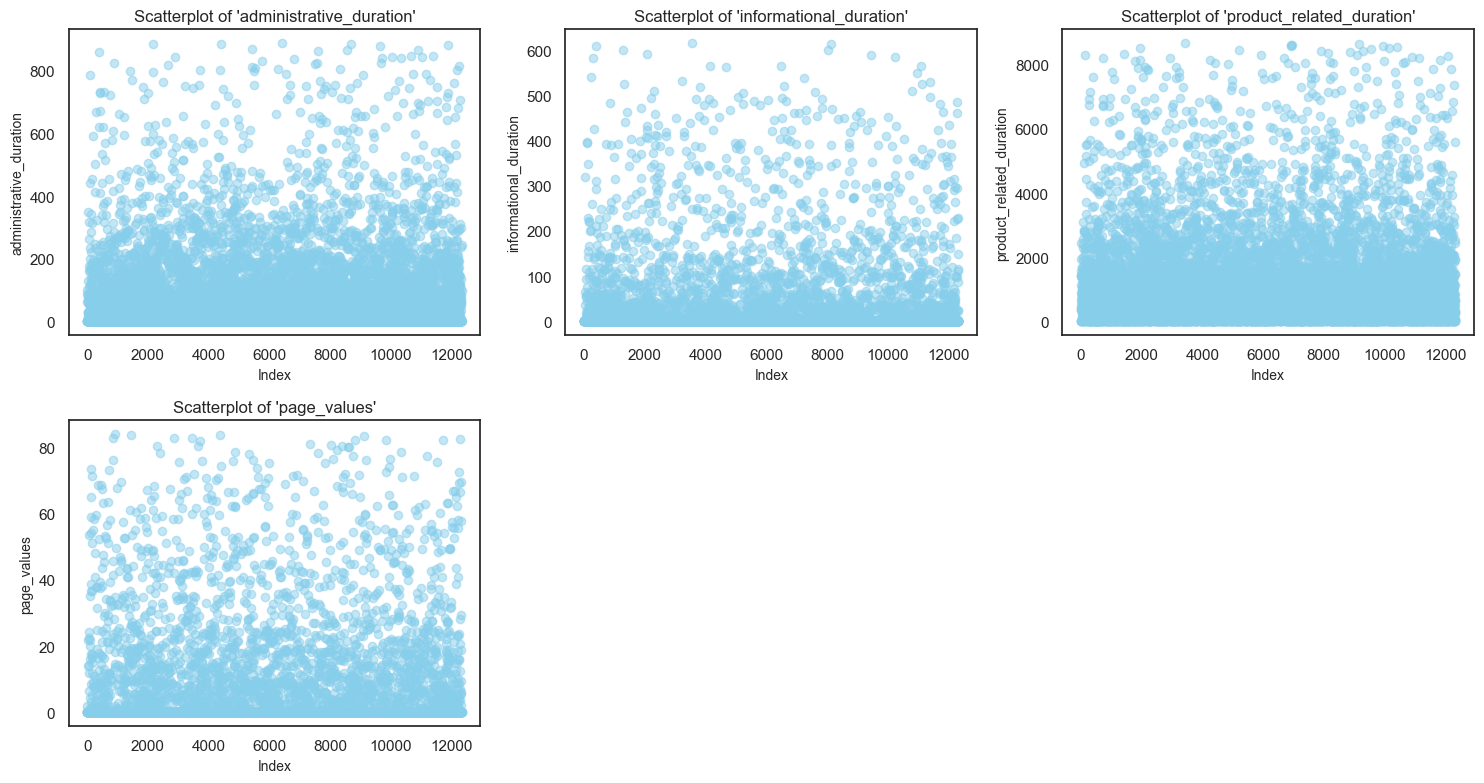

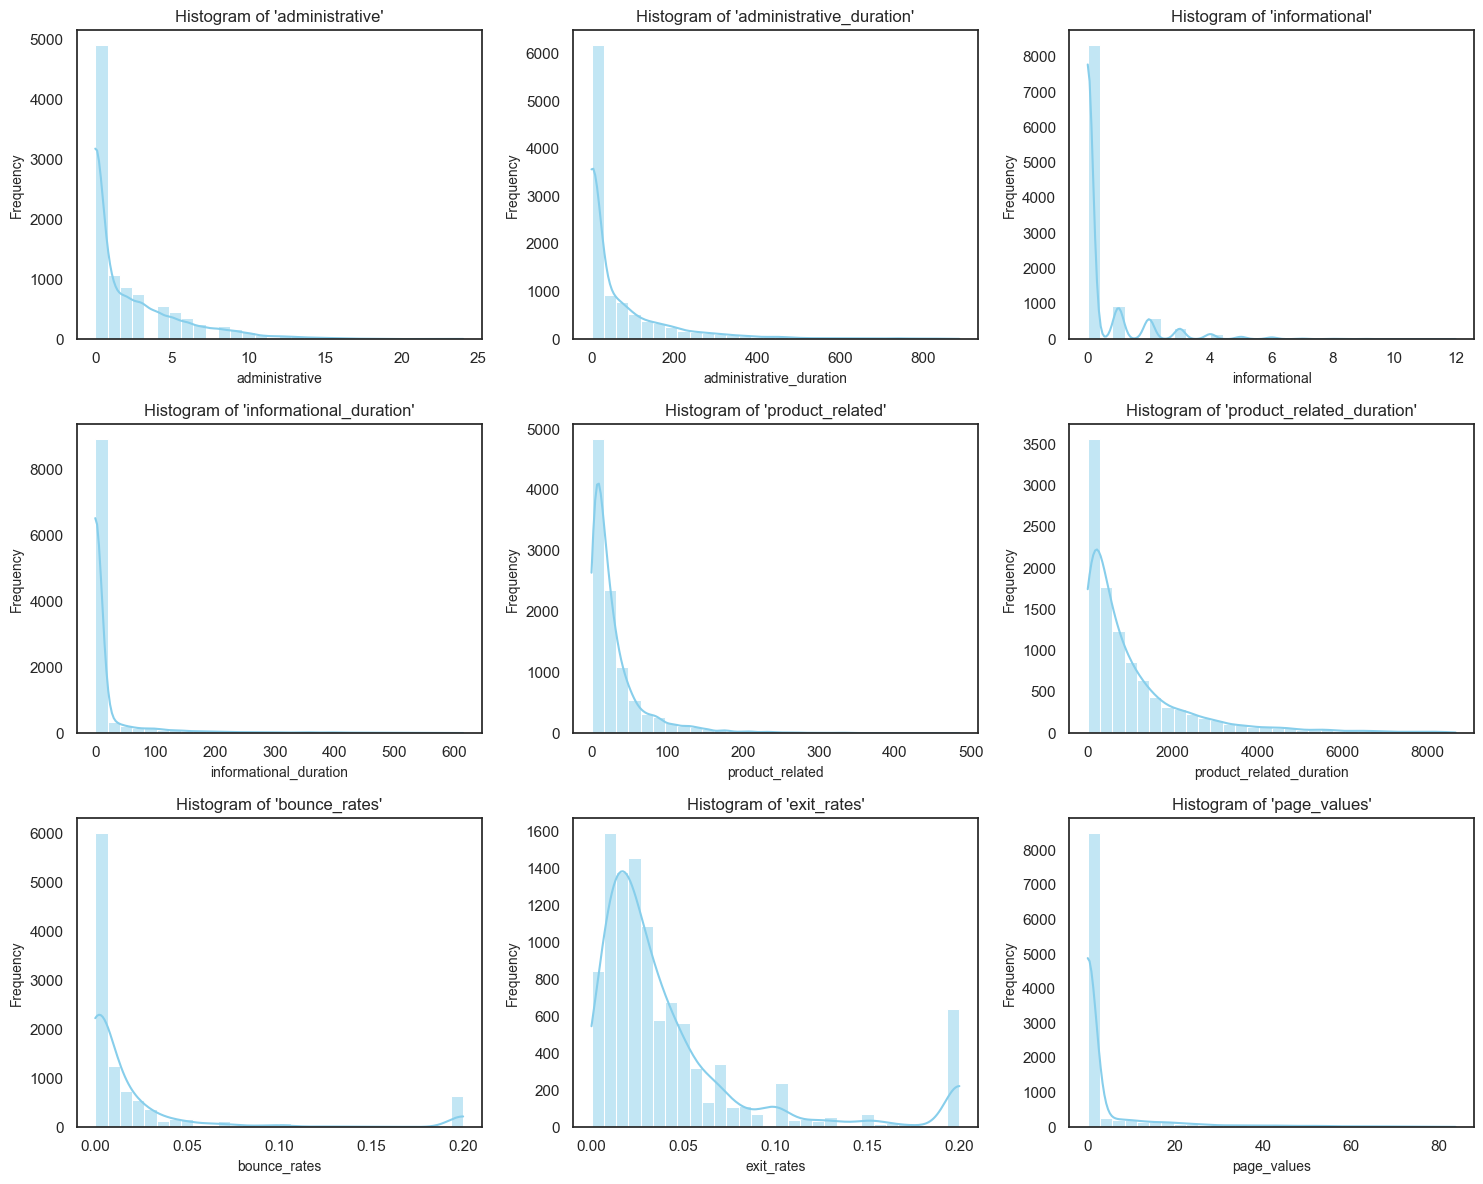

In [91]:
%reload_ext autoreload
%autoreload 2

Plotter(df_sans_outliers).numeric_distributions(columns=cols_with_outliers, plot_type='scatter', highlight_outliers=False)
Plotter(df_sans_outliers).numeric_distributions(plot_type='hist')

# Visualise Correlation Heatmap

We can observe from the below heatmap that the cols `bounce_rates` and `exit_rates` are significantly correlated, with a coeficient of 0.91. This means they represent largely the exact same data, and one of the columns can be dropped.

We drop 'exit_rates' as we will want to analyze bounce rates specifically in a later exercise.

We can also see that the specific activities and their durations are also quite heavily correlated, however dropping any of these columns would be losing valuable data.

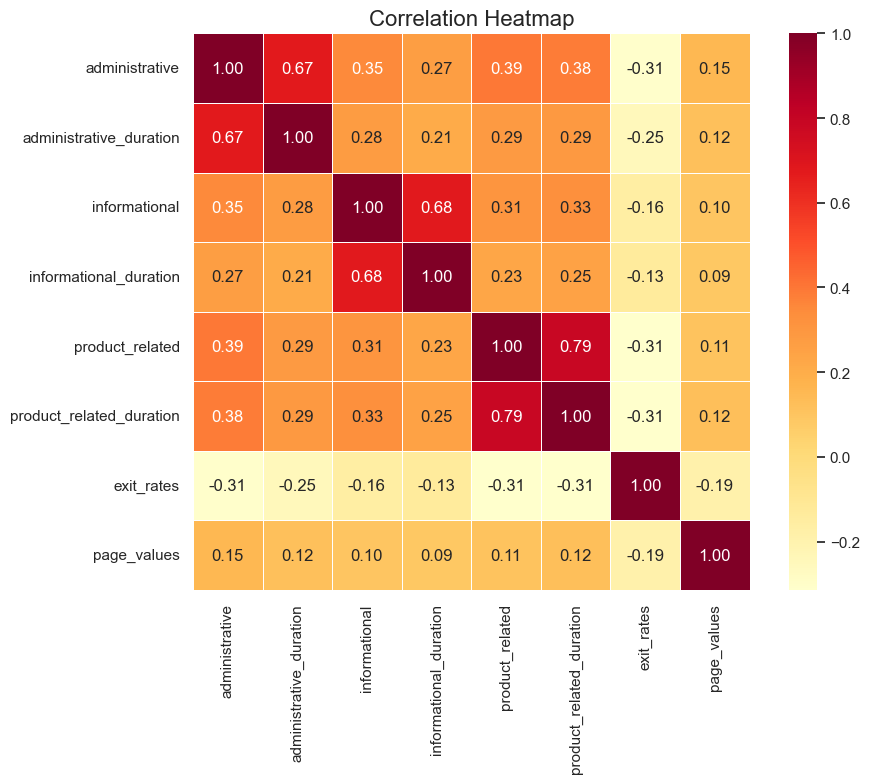

Drop the 'exit_rates' column.


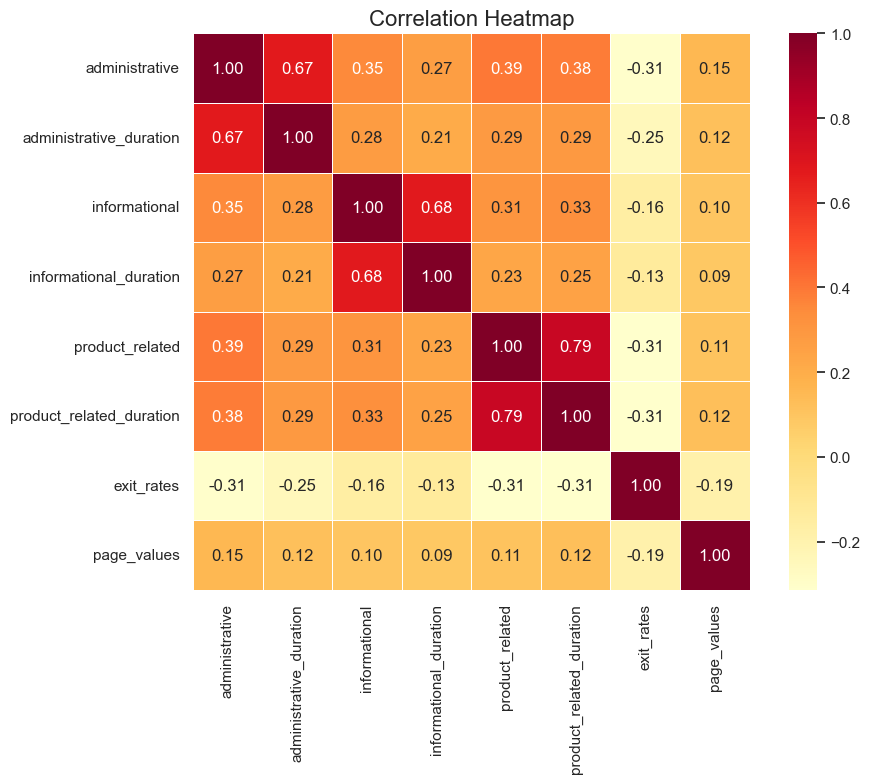

In [93]:
%reload_ext autoreload
%autoreload 2

plot = Plotter(df_sans_outliers)
plot.correlation_map()

print("Drop the 'exit_rates' column.")
if "bounce_rates" in df_sans_outliers.columns:
    df_sans_outliers = df_sans_outliers.drop(columns="bounce_rates")

plot = Plotter(df_sans_outliers)
plot.correlation_map()

# Voila

After all that, we get ourselves a clean dataframe that we will be using in the `data_vis` notebook to gain insights from. :)

In [94]:
df_sans_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10502 entries, 0 to 12329
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   administrative            10010 non-null  Int32   
 1   administrative_duration   10502 non-null  float64 
 2   informational             10502 non-null  Int32   
 3   informational_duration    10502 non-null  float64 
 4   product_related           10006 non-null  Int32   
 5   product_related_duration  10502 non-null  float64 
 6   exit_rates                10502 non-null  float64 
 7   page_values               10502 non-null  float64 
 8   month                     10502 non-null  category
 9   operating_systems         10492 non-null  category
 10  browser                   10502 non-null  category
 11  region                    10502 non-null  category
 12  traffic_type              10502 non-null  category
 13  visitor_type              10502 non-null  category
